# Generating Abdominal CT slices using a Simple Diffusion-GAN Model

# 1.Importing the important packages

In [1]:
import os             #for accessing files using path and perform path operations
import pydicom        #for dealing with dcm or diocm files
import cv2            #for resize the image
import numpy as np
from tqdm import tqdm #for progress bat

# 2.Function(data_loader) for loading the CT scan slices into a list

In [2]:
def data_loader(folder_path, target_size=(128,128)):
    slices=[]
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith('.dcm'):
            file_path =  os.path.join(folder_path, file_name)
            dicm = pydicom.dcmread(file_path)
            img = dicm.pixel_array.astype(np.float32)
            img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)#cv2.INTER_AREA: This interpolation method is best suited for shrinking or downscaling an image. It uses pixel area relation and provides the best results for reducing image dimensions.
            iimg = (img - np.min(img)) / (np.max(img) - np.min(img))  # [0, 1]
            img = (img * 2) - 1  # Convert to [-1, 1]
            slices.append(img)
    return slices

# 3.Data Preprocessing

In [3]:
all_slices=[]
basedir="/kaggle/input/chaos-dataset/CHAOS_Train_Sets/Train_Sets/CT"
patients_dir = sorted(os.listdir(basedir))
print(patients_dir)
for patient in tqdm(patients_dir):
    dicom_folder = os.path.join(basedir,patient,"DICOM_anon")#Constructs the path to a folder containing anonymized DICOM files for the current patient.
    slices = data_loader(dicom_folder)
    all_slices.extend(slices)
all_slices = np.array(all_slices)
print("Total slices:",all_slices.shape)

['1', '10', '14', '16', '18', '19', '2', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '5', '6', '8']


100%|██████████| 20/20 [00:40<00:00,  2.02s/it]

Total slices: (2874, 128, 128)


In [4]:
np.save("/kaggle/working/ct_train_preprocessed.npy", all_slices)
print("Saved preprocessed CT slices to working directory.")

Saved preprocessed CT slices to working directory.


# 4.GAN Implemetation

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
slices = np.load("/kaggle/working/ct_train_preprocessed.npy")#Loads a preprocessed NumPy array from a .npy file into memory.
slices = torch.tensor(slices).unsqueeze(1).float()#Converts the NumPy array (slices) into a PyTorch tensor, adds an extra dimension, and converts its data type to floating-point numbers.
slices = slices.to(device)#Moves the PyTorch tensor (slices) to a specific device (e.g., CPU or GPU).

In [7]:
dataset = TensorDataset(slices)
load =  DataLoader(dataset, batch_size = 64, shuffle = True)

# 5.Generator (U-Net Architecture)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNetGenerator, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder starts with in_channels + embedding channels (assume 1 channel for t_embed)
        self.initial_conv = self.double_conv(in_channels + 64, features[0])  # Adjust for 64 embedding channels
        in_channels = features[0]

        # Rest of the encoder
        for feature in features[1:]:  # Skip the first feature as it's handled by initial_conv
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self.double_conv(features[-1], features[-1] * 2)

        # Decoder
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(self.double_conv(feature * 2, feature))

        # Final layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Tanh() 
        )

    def forward(self, x, t):
        skip_connections = []

        # Timestep embedding
        t_embed = self.get_timestep_embedding(t, channels=64)  # 64 channels for embedding
        x = torch.cat([x, t_embed], dim=1)  # Concatenate to create 1 + 64 = 65 channels

        # Downsampling
        x = self.initial_conv(x)  # First conv handles the concatenated input
        skip_connections.append(x)
        x = self.pool(x)

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Upsampling
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

    @staticmethod
    def double_conv(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    @staticmethod
    def get_timestep_embedding(t, channels):
        half = channels // 2
        emb = torch.log(torch.tensor(10000.0)) / (half - 1)
        emb = torch.exp(-emb * torch.arange(half, device=t.device))
        emb = t.float()[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb.view(-1, channels, 1, 1).expand(-1, -1, 128, 128)  # Match image size

In [9]:
generator = UNetGenerator(in_channels=1, out_channels=1).to(device)#sample generator object

# 6.Discriminator (CNN)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()
        layers = []

        # Initial conv (no batchnorm)
        layers.append(
            nn.Sequential(
                nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2)
            )
        )

        # Next layers
        for i in range(1, len(features)):
            layers.append(
                nn.Sequential(
                    nn.Conv2d(features[i-1], features[i], kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(features[i]),
                    nn.LeakyReLU(0.2)
                )
            )

        # Final conv layer
        layers.append(
            nn.Conv2d(features[-1], 1, kernel_size=4, stride=1, padding=1)
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [11]:
discriminator = Discriminator(in_channels=1).to(device)#sample discriminator object

# 7.Loss Functions Used

1. BCEWithLogitsLoss – Adversarial Loss:
This is used for training the discriminator and generator in the GAN part.
It combines a Sigmoid + Binary Cross Entropy for better stability.
It helps the discriminator learn to tell real vs. fake images.
It helps the generator learn to produce images that look real.

2. MSELoss – Diffusion Noise Prediction Loss
Used for the diffusion part to train the generator to predict the added noise.
It measures pixel-wise accuracy between predicted and actual noise.
This keeps the output close to the ground truth, preserving CT details.


3. Why Use Both Together?
BCEWithLogitsLoss ensures the output looks realistic.
MSELoss ensures the output is accurate and denoised.
Used together in generator loss to balance realism + precision.

In [12]:
criterion = nn.BCEWithLogitsLoss()  # Adversarial loss
mse_loss = nn.MSELoss()

In [13]:
import torch.optim as optim

#Objects
gen = UNetGenerator(in_channels=1, out_channels=1).to(device)
disc = Discriminator(in_channels=1).to(device)

# Optimizers
gen_opt = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_opt = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [14]:
betas = torch.linspace(1e-4, 0.02, 1000)#	Noise amount at each timestep
alphas = 1.0 - betas#Signal-preservation at each timestep
alpha_hat = torch.cumprod(alphas, dim=0)#Total signal-preservation up to timestep t

In [15]:
def forward_diffusion_sample(x_0, t, alpha_hat):
    device = x_0.device  # get device from input tensor
    noise = torch.randn_like(x_0)
    
    # Ensure everything is on the same device
    t = t.to(device)
    alpha_hat = alpha_hat.to(device)
    
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    
    return sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise, noise


# 8.Training

In [16]:
# Update the training loop to use the new generator
from tqdm import tqdm

epochs = 50
T = 1000

for epoch in range(epochs):
    loop = tqdm(load, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in loop:
        real = batch[0].to(device)

        # Sample timestep t
        t = torch.randint(0, T, (real.size(0),), device=device).long()

        # Generate noisy image and noise
        x_t, noise = forward_diffusion_sample(real, t, alpha_hat)

        # Train Discriminator
        with torch.no_grad():
            pred_noise = gen(x_t, t)  # Predict noise
            fake = x_t - pred_noise   # Reconstruct fake image
        disc_real = disc(real)
        disc_fake = disc(fake)
        lossD = criterion(disc_real, torch.ones_like(disc_real) * 0.9) + \
                criterion(disc_fake, torch.zeros_like(disc_fake))
        disc_opt.zero_grad()
        lossD.backward()
        disc_opt.step()

        # Train Generator
        pred_noise = gen(x_t, t)
        fake = x_t - pred_noise
        disc_fake = disc(fake)
        lossG = criterion(disc_fake, torch.ones_like(disc_fake)) + \
                mse_loss(pred_noise, noise)  # Add noise prediction loss
        gen_opt.zero_grad()
        lossG.backward()
        gen_opt.step()

        loop.set_postfix(lossD=lossD.item(), lossG=lossG.item())

Epoch 50/50: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it, lossD=0.337, lossG=6.74]


In [17]:
gen = UNetGenerator(in_channels=1, out_channels=1).to(device)
disc = Discriminator().to(device)

In [18]:
# Save the model state dictionaries
torch.save(gen.state_dict(), "unet_generator1.pth")
torch.save(disc.state_dict(), "discriminator1.pth")

print("Models saved successfully!")

Models saved successfully!


Neural Schema for Generator:

In [19]:
gen = UNetGenerator(in_channels=1, out_channels=1).to(device)
gen.load_state_dict(torch.load("unet_generator1.pth"))
gen.eval()

UNetGenerator(
  (downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): Sequential(
      (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
 

Neural Schema for Discriminator

In [20]:
disc = Discriminator().to(device)
disc.load_state_dict(torch.load("discriminator1.pth"))
disc.eval()

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

# 9.Visualization of Generated images

Scenario 1: Generating from Pure Noise
Generated Image (rescaled): tensor([[[[ 0.5921,  0.6671,  1.1238,  ...,  0.0874,  0.2075,  0.4407],
          [ 0.6379,  0.4139, -0.9859,  ...,  0.5824,  1.0714,  1.8588],
          [ 0.3404, -0.4306, -0.2349,  ...,  0.7078,  0.5226, -0.0049],
          ...,
          [ 1.1049,  1.0994,  0.5230,  ...,  0.2071,  0.7467,  0.4879],
          [ 0.6107, -0.0625,  0.9449,  ..., -0.3029,  0.9962,  0.5413],
          [ 0.6557,  0.5672,  0.5663,  ...,  0.3746,  1.1899,  0.9655]]]],
       device='cuda:0')


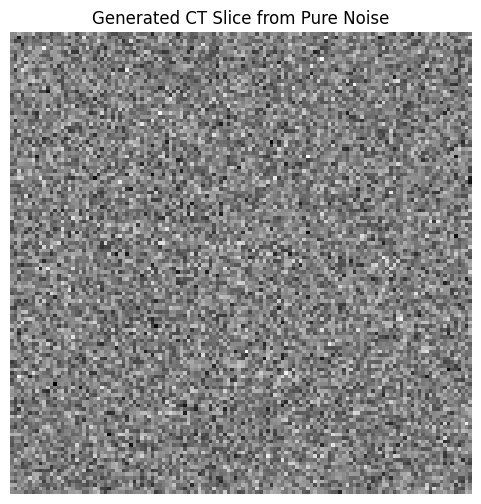

Discriminator Output Shape: torch.Size([1, 1, 7, 7])
Discriminator Output for Pure Noise Generation: 0.010347493924200535
Discriminator Loss (assuming real): 0.6879868507385254

Scenario 2: Denoising Partially Noised Real Image


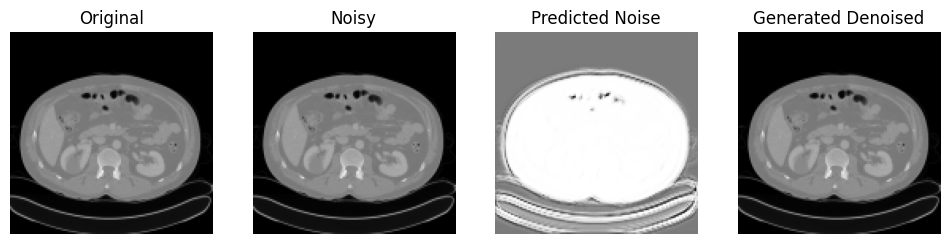

Discriminator Output Shapes: torch.Size([64, 1, 7, 7]) torch.Size([64, 1, 7, 7]) torch.Size([64, 1, 7, 7])
Discriminator Output - Real: 14.90527057647705
Discriminator Output - Noisy: 5.739530563354492
Discriminator Output - Generated: 2.8756401538848877
Discriminator Loss - Real: 3.362971483511501e-07
Discriminator Loss - Noisy: 0.003211116651073098
Discriminator Loss - Generated (as real): 0.05484800040721893


In [22]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Load the saved models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = UNetGenerator(in_channels=1, out_channels=1).to(device)
disc = Discriminator(in_channels=1).to(device)
gen.load_state_dict(torch.load("unet_generator1.pth"))
disc.load_state_dict(torch.load("discriminator1.pth"))
gen.eval()
disc.eval()

# Loss function for evaluation
criterion = nn.BCEWithLogitsLoss()

# Scenario 1: Generate from Pure Noise
print("Scenario 1: Generating from Pure Noise")
# Simulated noised image (shape [1, 1, 128, 128])
noised_image = torch.randn((1, 1, 128, 128)).to(device)

# Define a timestep (e.g., 25)
timestep = torch.tensor([25]).to(device)

# Generate synthetic image
with torch.no_grad():
    pred_noise = gen(noised_image, timestep)  # Predict noise
    fake_image = noised_image - pred_noise    # Reconstruct image
    fake_image = (fake_image + 1) / 2        # Rescale from [-1, 1] to [0, 1]

print("Generated Image (rescaled):", fake_image)
plt.figure(figsize=(6, 6))
plt.imshow(fake_image.squeeze().cpu().numpy(), cmap='gray')
plt.title("Generated CT Slice from Pure Noise")
plt.axis('off')
plt.show()

# Evaluate with Discriminator
with torch.no_grad():
    disc_output = disc(fake_image)  # Get discriminator output
    print("Discriminator Output Shape:", disc_output.shape)  # Debug shape
    # Reduce to scalar: average over all non-batch dimensions
    disc_output = disc_output.mean()  # Average over all elements
    disc_loss = criterion(disc_output.unsqueeze(0), torch.ones_like(disc_output.unsqueeze(0)))  # Treat as real
print("Discriminator Output for Pure Noise Generation:", disc_output.item())
print("Discriminator Loss (assuming real):", disc_loss.item())

# Scenario 2: Denoise Partially Noised Real Image
print("\nScenario 2: Denoising Partially Noised Real Image")
real = next(iter(load))[0].to(device)  # Get a batch of real images
t = torch.randint(0, 1000, (real.size(0),), device=device).long() #adjust the initial value 0 for getting more noise in the image
x_t, _ = forward_diffusion_sample(real, t, alpha_hat)

gen.eval()
with torch.no_grad():
    pred_noise = gen(x_t, t)  # Predict noise
    fake = x_t - pred_noise   # Reconstruct image
    fake = (fake + 1) / 2    # Rescale from [-1, 1] to [0, 1]

# Show result
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(real[0, 0].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Noisy")
plt.imshow(x_t[0, 0].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Predicted Noise")
plt.imshow(pred_noise[0, 0].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Generated Denoised")
plt.imshow(fake[0, 0].cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# Evaluate with Discriminator
with torch.no_grad():
    disc_output_real = disc(real)
    disc_output_noisy = disc(x_t)
    disc_output_fake = disc(fake)
    print("Discriminator Output Shapes:", disc_output_real.shape, disc_output_noisy.shape, disc_output_fake.shape)  # Debug
    # Reduce to scalar for each
    disc_output_real = disc_output_real.mean()
    disc_output_noisy = disc_output_noisy.mean()
    disc_output_fake = disc_output_fake.mean()
    disc_loss_real = criterion(disc_output_real.unsqueeze(0), torch.ones_like(disc_output_real.unsqueeze(0)))
    disc_loss_noisy = criterion(disc_output_noisy.unsqueeze(0), torch.ones_like(disc_output_noisy.unsqueeze(0)))
    disc_loss_fake = criterion(disc_output_fake.unsqueeze(0), torch.ones_like(disc_output_fake.unsqueeze(0)))
print("Discriminator Output - Real:", disc_output_real.item())
print("Discriminator Output - Noisy:", disc_output_noisy.item())
print("Discriminator Output - Generated:", disc_output_fake.item())
print("Discriminator Loss - Real:", disc_loss_real.item())
print("Discriminator Loss - Noisy:", disc_loss_noisy.item())
print("Discriminator Loss - Generated (as real):", disc_loss_fake.item())